In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
plt.rc('font', family='Malgun Gothic')  # Windows
plt.rc('axes', unicode_minus=False)  # 마이너스 기호 깨짐 방지


file_path = "dataset/prices.csv"
data = pd.read_csv(file_path)

data['date'] = pd.to_datetime(data['date'], format='mixed', errors='coerce')  # 날짜 변환
data = data.dropna(subset=['date'])  # 변환 실패한 데이터 제거(결측치 제거)
data = data.sort_values('date')  # 시간 순서대로 정렬


In [14]:
data = data[['date', 'volume']].copy() #필요한 컬럼 선택 대입
data.set_index('date', inplace=True) #date열을 행의 인덱스로 설정

In [15]:
scaler = MinMaxScaler()
data['volume'] = scaler.fit_transform((data[['volume']])) #쩡규화

In [16]:
#시계열 데이터 생성함수
def create_sequences(data, sequence_length): #과거 데이터 길이이
    X,y = [] , []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length]) #i 부터 과거 데이터 길이 -1 까지
        y.append(data[i + sequence_length]) # i + 과거 데이터 길이 만큼
    return np.array(X), np.array(y)

In [17]:
#시계열 데이터 준비
sequence_length = 10 #과거 10일 데이터 사용
X,y = create_sequences(data['volume'].values, sequence_length)

In [18]:
#데이터분할~
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1)) #X_train의 행 개수와 동일 , 각 샘플의 시퀀스 길이 , 사용할 컬럼 개수
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [19]:
#LSTM 모델 구성
model = Sequential([
    LSTM(50,activation='relu', input_shape=(sequence_length, 1)),
    Dense(1)
])

c:\python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(optimizer='adam', loss='mse')

In [21]:
histroy = model.fit(X_train,y_train,epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 2.2049e-04 - val_loss: 1.9774e-04
Epoch 2/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 2.1495e-04 - val_loss: 1.9740e-04
Epoch 3/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 2.2476e-04 - val_loss: 1.9882e-04
Epoch 4/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 2.1568e-04 - val_loss: 1.9789e-04
Epoch 5/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 2.1225e-04 - val_loss: 2.0201e-04
Epoch 6/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 2.1842e-04 - val_loss: 1.9778e-04
Epoch 7/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - loss: 2.1997e-04 - val_loss: 1.9841e-04
Epoch 8/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 2.2014e-04 - val_loss: 1.9852e-04
Epoch 9/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - loss: 2.2174e-04 - val_loss: 1.9698e-04
Epoch 10/20
17026/17026 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 2.0999e-04 - val_loss: 1.9803e-04
Epoch 11/

In [23]:
loss = model.evaluate(X_test,y_test) #모델 성능 평가함수
print(f"Test Loss: {loss}")

5321/5321 ━━━━━━━━━━━━━━━━━━━━ 5s 859us/step - loss: 2.0557e-04
Test Loss: 0.00020220615260768682


In [24]:
#예측 및 역정규화
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred.reshape(-1,1))
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

5321/5321 ━━━━━━━━━━━━━━━━━━━━ 4s 696us/step


모델 학습과정

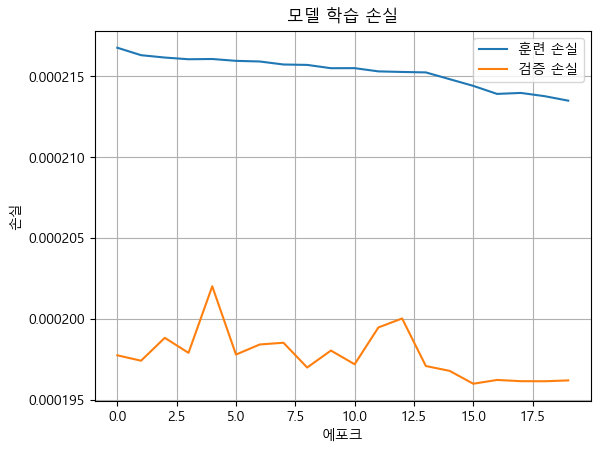

In [41]:
#학습중 손실 감소 추이 확인
plt.plot(histroy.history['loss'], label='훈련 손실')
plt.plot(histroy.history['val_loss'], label='검증 손실')
plt.title("모델 학습 손실")
plt.xlabel("에포크")
plt.ylabel("손실")
plt.legend()
plt.grid()
plt.show()


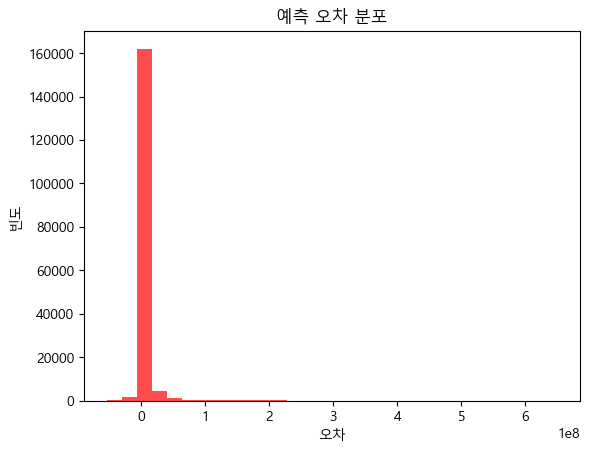

In [43]:
errors = y_test_rescaled - y_pred_rescaled
plt.hist(errors, bins=30, color='red', alpha=0.7)
plt.title("예측 오차 분포")
plt.xlabel("오차")
plt.ylabel("빈도")
plt.show()


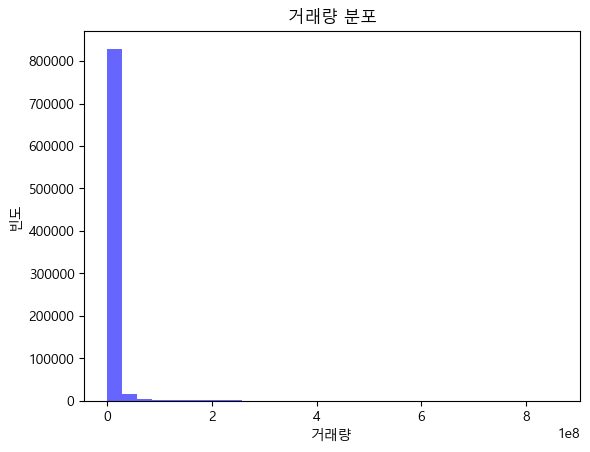

In [46]:
#히스토그램
plt.hist(data['volume'], bins=30, color='blue', alpha=0.6)
plt.title("거래량 분포")
plt.xlabel("거래량")
plt.ylabel("빈도")
plt.show()


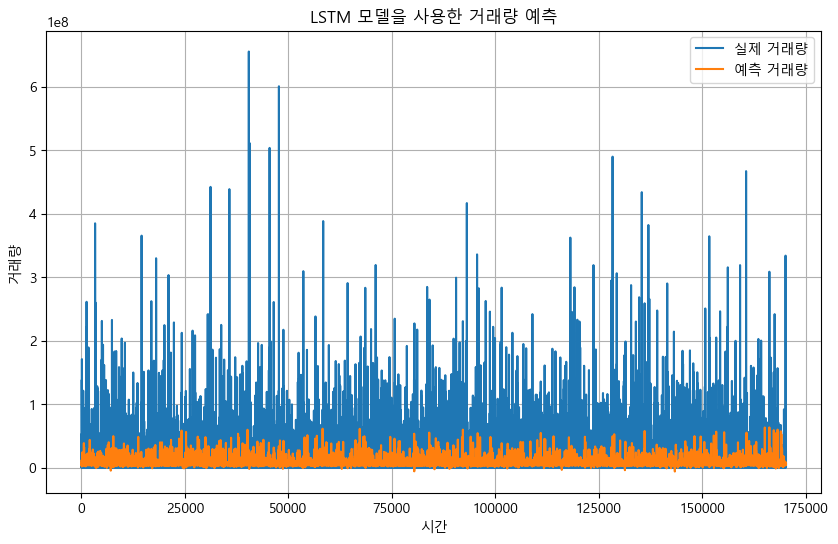

In [30]:
# 시각화: 실제 거래량과 예측 거래량 비교
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='실제 거래량')
plt.plot(y_pred_rescaled, label='예측 거래량')
plt.title("LSTM 모델을 사용한 거래량 예측")
plt.xlabel("시간")
plt.ylabel("거래량")
plt.legend()
plt.grid()
plt.show()
